##### Imports

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime



from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

Data Imports

The following 2 lines of code allow us to work with the the files "historical.xlsx" and "predict.xlsx" if they are on our drive. Click in the icon on the left "Ficheiros" or "Folder" and drop there the data files. Every new session you have to do repeat this process.   

In [5]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [6]:
train = pd.read_excel(r"historical.xlsx")

test= pd.read_excel(r"predict.xlsx")

train.set_index('CustomerID', inplace = True)
test.set_index('CustomerID', inplace = True)

## Initial Feature Engineering

In [7]:
for df in [train, test]:
# Gender creation
    df['Gender'] = np.where(df['Name'].str.contains('Mr.'), 'M', 'F')

# Antiquity creation
    df[df.Date_Adherence.apply(lambda x: isinstance(x, str))]                                         #16 cases of string 2/29/2022
    df.loc[df.Date_Adherence.apply(lambda x: isinstance(x, str)), 'Date_Adherence'] = '3/01/2022'     # Converted to 3/01/2022 and to datetime object
    df['Date_Adherence'] = pd.to_datetime(df['Date_Adherence'])
    df['Antiquity'] = (datetime.today() - df['Date_Adherence']).dt.days
    df['Antiquity'] = df['Antiquity'].astype(int)

# Age creation
    df['Age'] = datetime.now().year - df.Birthyear
    df['Age'] = df['Age'].astype(int)

#Freq creation
    df['Freq'] = df[['NumAppPurchases', 'NumTakeAwayPurchases', 'NumStorePurchases', 'NumOfferPurchases']].sum(axis=1)

#Amount Total creation
    df['Mnt_Total'] = df[['MntMeat&Fish', 'MntEntries', 'MntVegan&Vegetarian', 'MntDrinks', 'MntDesserts','MntAdditionalRequests']].sum(axis=1)

#Drop irrelevant cols
    df.drop(['Name', 'Birthyear', 'Date_Adherence'], axis=1, inplace=True)

## EDA

In [8]:
train.drop_duplicates(inplace=True)

In [9]:
numeric = train[[
    'Income', 'Recency', 'MntMeat&Fish', 'MntEntries', 'MntVegan&Vegetarian', 'MntDrinks', 'MntDesserts', 'MntAdditionalRequests',
    'NumOfferPurchases', 'NumAppPurchases', 'NumTakeAwayPurchases', 'NumStorePurchases', 'NumAppVisitsMonth', 'Antiquity', 'Age', 'Freq', 'Mnt_Total'
    ]].copy()

categorical = train[[
    'Education', 'Marital_Status', 'Kid_Younger6', 'Children_6to18', 'Response_Cmp2', 'Response_Cmp3', 'Response_Cmp4', 
    'Response_Cmp5', 'Response_Cmp1', 'Complain', 'DepVar', 'Gender'
    ]].copy()

### Categorical

In [10]:
categorical.astype('object').describe()

,Education,Marital_Status,Kid_Younger6,Children_6to18,Response_Cmp2,Response_Cmp3,Response_Cmp4,Response_Cmp5,Response_Cmp1,Complain,DepVar,Gender
count,2468,2500,2500,2500,2500,2500,2500,2500,2500,2500,2500,2500
unique,5,10,3,3,2,2,2,2,2,2,2,2
top,Graduation,Married,0,0,0,0,0,0,0,0,0,M
freq,1251,1009,1463,1306,2297,2330,2303,2341,2470,2468,2187,1990


In [11]:
train.Education.value_counts()

Graduation    1251
PhD            522
Master         404
HighSchool     225
Basic           66
Name: Education, dtype: int64

In [12]:
train.Marital_Status.value_counts()

Married     1009
Together     592
Single       533
Divorced     212
Widow         82
married       37
single        15
together       9
divorced       6
widow          5
Name: Marital_Status, dtype: int64

### Numeric

In [13]:
numeric.describe()

,Income,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Antiquity,Age,Freq,Mnt_Total
count,2500.00000,2452.000000,2500.000000,2500.0000,2500.00000,2479.000000,2500.00000,2500.000000,2500.000000,2500.000000,2500.0000,2500.000000,2500.00000,2500.000000,2500.000000,2500.000000,2500.000000
mean,77557.22760,48.983279,3071.254400,526.5824,2748.27880,545.916499,524.16320,42.555600,2.454400,5.996800,3.8524,5.828400,5.29280,682.519200,46.379200,18.132000,7454.165200
std,35505.41711,28.636798,3376.433081,761.3516,3875.42553,793.028804,763.86874,49.576031,2.300356,2.757214,3.4258,3.339134,2.71286,203.504919,11.897631,7.972854,7581.458263
min,2678.00000,0.000000,0.000000,0.0000,5.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000,338.000000,18.000000,0.000000,18.000000
25%,50998.00000,25.000000,240.000000,40.0000,225.00000,40.000000,40.00000,8.000000,1.000000,4.000000,1.0000,3.000000,3.00000,507.000000,38.000000,11.000000,766.750000
50%,76684.50000,48.000000,1795.000000,180.0000,1110.00000,180.000000,180.00000,24.000000,2.000000,6.000000,3.0000,5.000000,6.00000,674.000000,45.000000,18.000000,4753.500000
75%,101712.00000,73.000000,5050.000000,680.0000,3693.75000,700.000000,680.00000,57.000000,3.000000,8.000000,5.0000,8.000000,7.00000,858.000000,56.000000,24.000000,12585.000000
max,237117.00000,99.000000,14980.000000,3980.0000,24886.00000,3960.000000,3980.00000,249.000000,16.000000,13.000000,24.0000,13.000000,20.00000,1036.000000,75.000000,42.000000,32657.000000


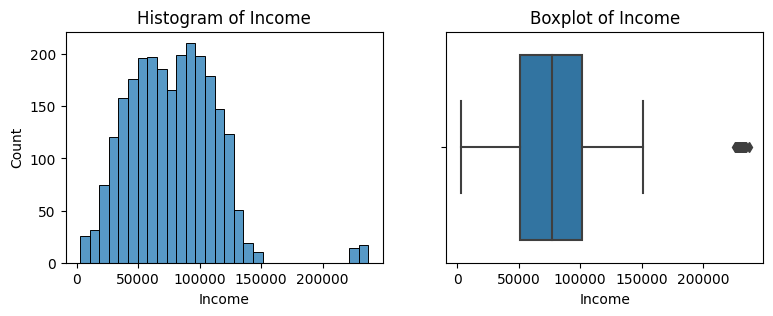

Skew: 0.8279467543830179, Kurtosis : 2.550323618111481


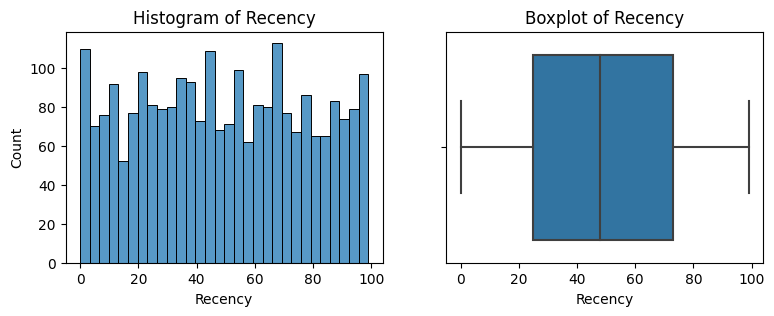

Skew: 0.028003334183665678, Kurtosis : -1.150535984763835


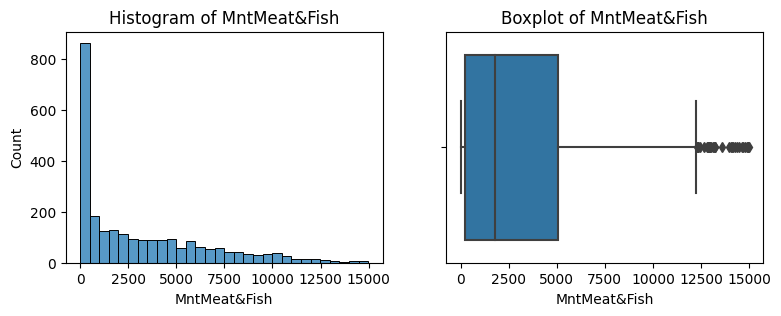

Skew: 1.135132472979566, Kurtosis : 0.4774072234927962


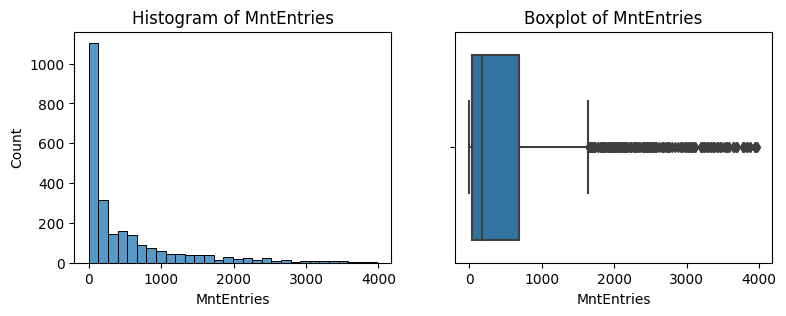

Skew: 2.091728377666883, Kurtosis : 4.292902198701057


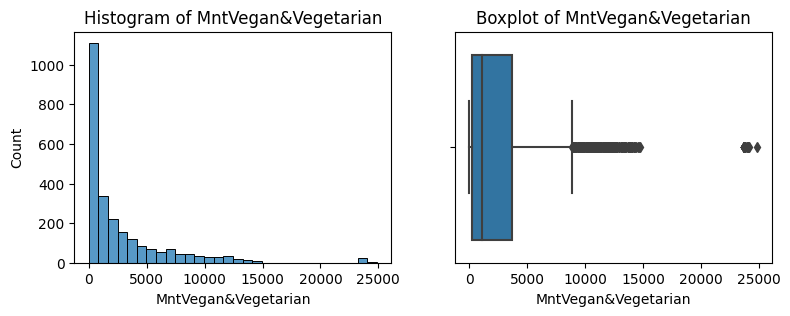

Skew: 2.4795529647990464, Kurtosis : 8.099056921985124


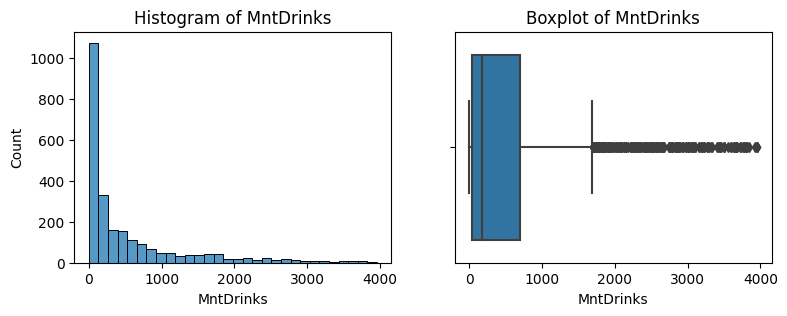

Skew: 2.01621025032237, Kurtosis : 3.7427002389973048


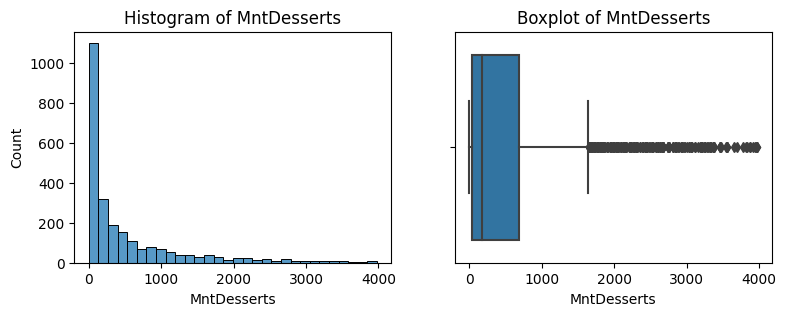

Skew: 2.071036987626397, Kurtosis : 4.0847740838963835


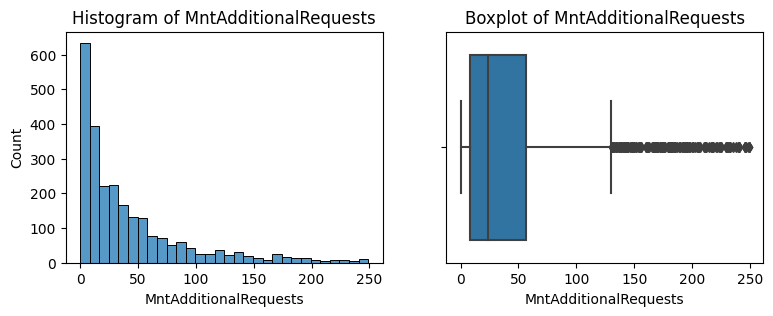

Skew: 1.8497950464594828, Kurtosis : 3.246925765909702


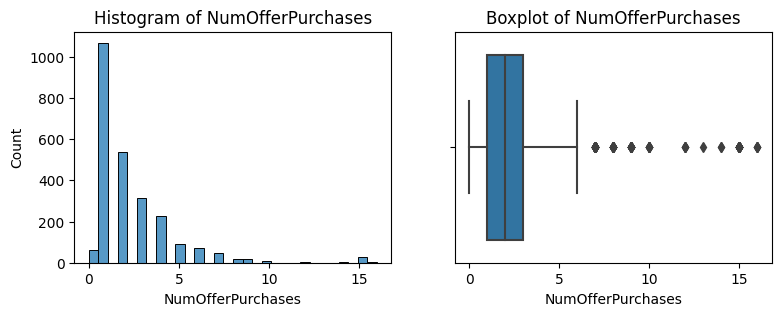

Skew: 2.8754868798433155, Kurtosis : 11.29364854186155


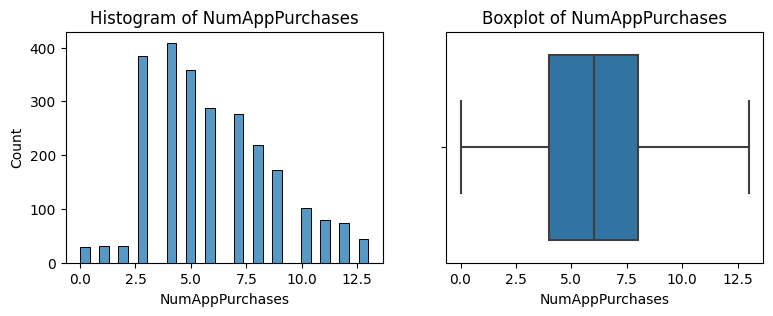

Skew: 0.5352427343804749, Kurtosis : -0.2154201568874261


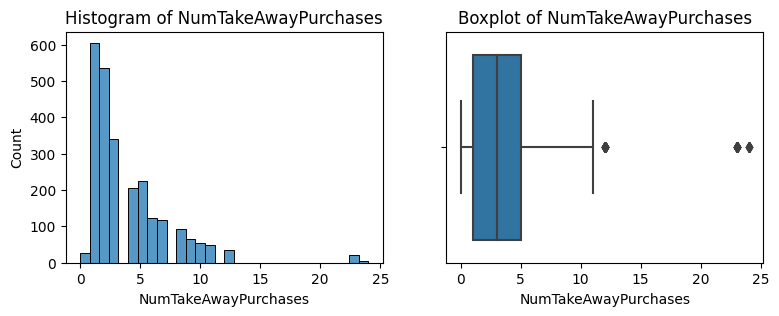

Skew: 2.3900164618425097, Kurtosis : 9.14690092475826


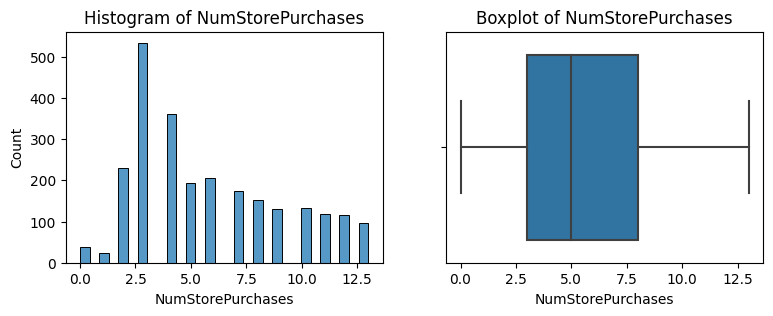

Skew: 0.6119897083696106, Kurtosis : -0.7240328472444681


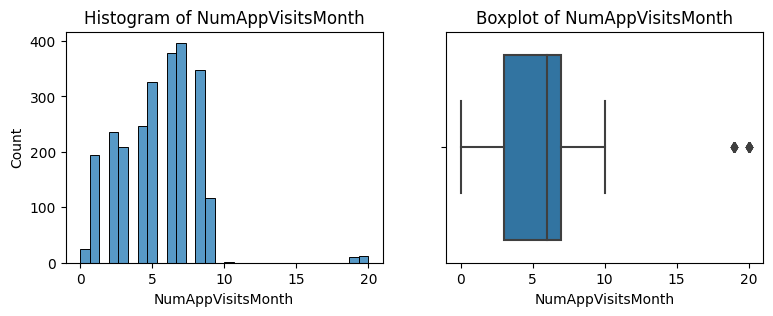

Skew: 0.9706319237195967, Kurtosis : 4.989026719884712


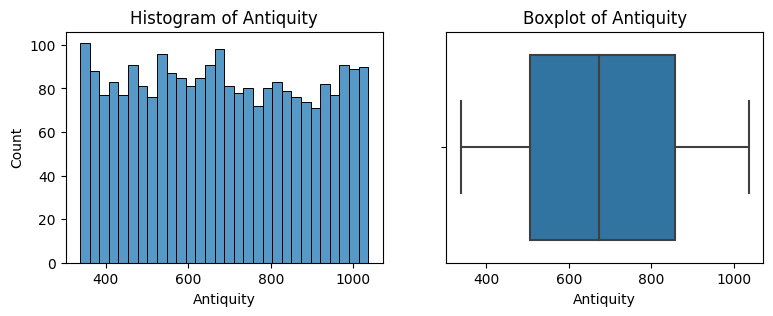

Skew: 0.0427689679463382, Kurtosis : -1.1915784398953502


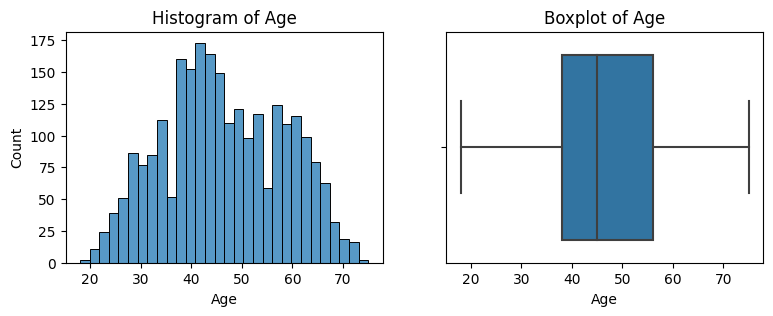

Skew: 0.06304240758491092, Kurtosis : -0.8168653337922467


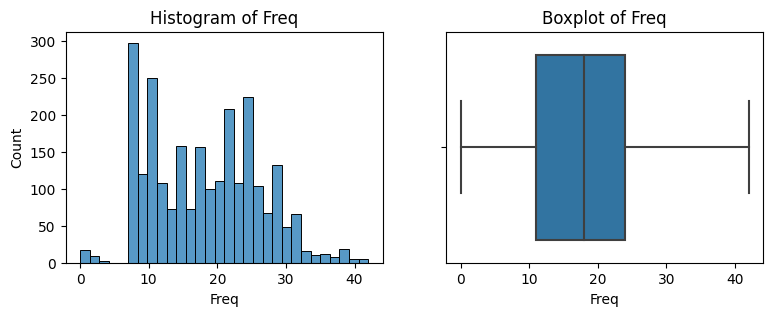

Skew: 0.22520269262336717, Kurtosis : -0.7142312507954243


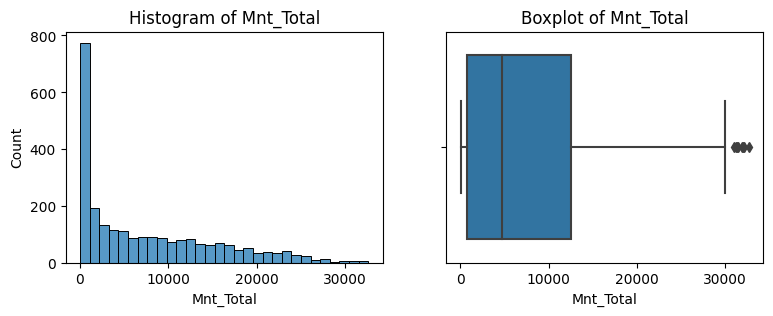

Skew: 0.9429060100563523, Kurtosis : -0.1328564214356307


In [14]:
for var in numeric:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))
    sns.histplot(ax=ax1, x=numeric[var], bins=30)
    sns.boxplot(ax=ax2, x=numeric[var])
    ax1.set_title(f"Histogram of {var}")
    ax2.set_title(f"Boxplot of {var}")
    plt.show()
    print(f'Skew: {numeric[var].skew()}, Kurtosis : {numeric[var].kurt()}')


OUTLIERS

source: https://hwbdocuments.env.nm.gov/Los%20Alamos%20National%20Labs/TA%2054/11587.pdf

In [15]:
import numpy as np
from scipy import stats

total=0
for i in numeric:
    # Generate a sample dataset
    data = numeric[i]

    # Calculate Z-scores
    z_scores = np.abs(stats.zscore(data))

    # Define a threshold for outlier detection
    threshold = 4  # Adjust this value based on your requirements

    # Identify outliers
    outliers = np.where(z_scores > threshold)[0]
    total += len(outliers)



    if len(outliers) > 0:
        print(f'{i} has {len(outliers)} outliers')
print(total)

Income has 31 outliers
MntEntries has 17 outliers
MntVegan&Vegetarian has 25 outliers
MntDesserts has 12 outliers
MntAdditionalRequests has 11 outliers
NumOfferPurchases has 38 outliers
NumTakeAwayPurchases has 26 outliers
NumAppVisitsMonth has 22 outliers
182


IQR Method without variables normalization. As you can see through the results, if we apply IQR method to identify outliers we'll be without our dataset :D

In [16]:
total_iqr = 0

for i in numeric:
  numeric[i]+=1

  Q1 = np.percentile(numeric[i], 25)
  Q3 = np.percentile(numeric[i], 75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 + IQR
  upper_bound = Q3 + 1.5 * IQR

  outliers = numeric[(numeric[i] < lower_bound) | (numeric[i] > upper_bound)]
  total_iqr += len(outliers)

  if len(outliers) > 0:
    print(f'{i} has {len(outliers)} outliers\n')
  else:
    print(f'{i} has NO outliers\n')

print(total_iqr)

Income has 1906 outliers

Recency has NO outliers

MntMeat&Fish has 1908 outliers

MntEntries has 2102 outliers

MntVegan&Vegetarian has 2081 outliers

MntDrinks has NO outliers

MntDesserts has 2113 outliers

MntAdditionalRequests has 2046 outliers

NumOfferPurchases has 1255 outliers

NumAppPurchases has 1533 outliers

NumTakeAwayPurchases has 1567 outliers

NumStorePurchases has 1583 outliers

NumAppVisitsMonth has 1259 outliers

Antiquity has 1872 outliers

Age has 1783 outliers

Freq has 1677 outliers

Mnt_Total has 1883 outliers

26568


Applying Modified Z-Score (Uses the median) 

In [17]:
total_m = 0
for i in numeric:
    numeric[i]+=1

    # Median Absolute Deviation (MAD)
    median = np.median(numeric[i])
    mad = np.median(np.abs(numeric[i] - median))

    # Modified Z-scores
    modified_z_scores = 0.6745 * (numeric[i] - median) / mad

    # Define a threshold for outlier detection
    threshold = 4  # Adjust this value based on your requirements. 

    # Identify outliers
    outliers = np.where(np.abs(modified_z_scores) > threshold)[0]
    total_m += len(outliers)

    if len(outliers) > 0:
        print(f'{i} has {len(outliers)} outliers\n')
print(total_m)

Income has 28 outliers

MntMeat&Fish has 44 outliers

MntEntries has 351 outliers

MntVegan&Vegetarian has 314 outliers

MntDesserts has 349 outliers

MntAdditionalRequests has 180 outliers

NumOfferPurchases has 79 outliers

NumTakeAwayPurchases has 26 outliers

NumAppVisitsMonth has 22 outliers

Mnt_Total has 8 outliers

1401


Log transformation — all variables that are not normally distributed included. 

If we'll be using the transformed variables on model building maybe we'll try more transformations to improve the normality of the distributions.

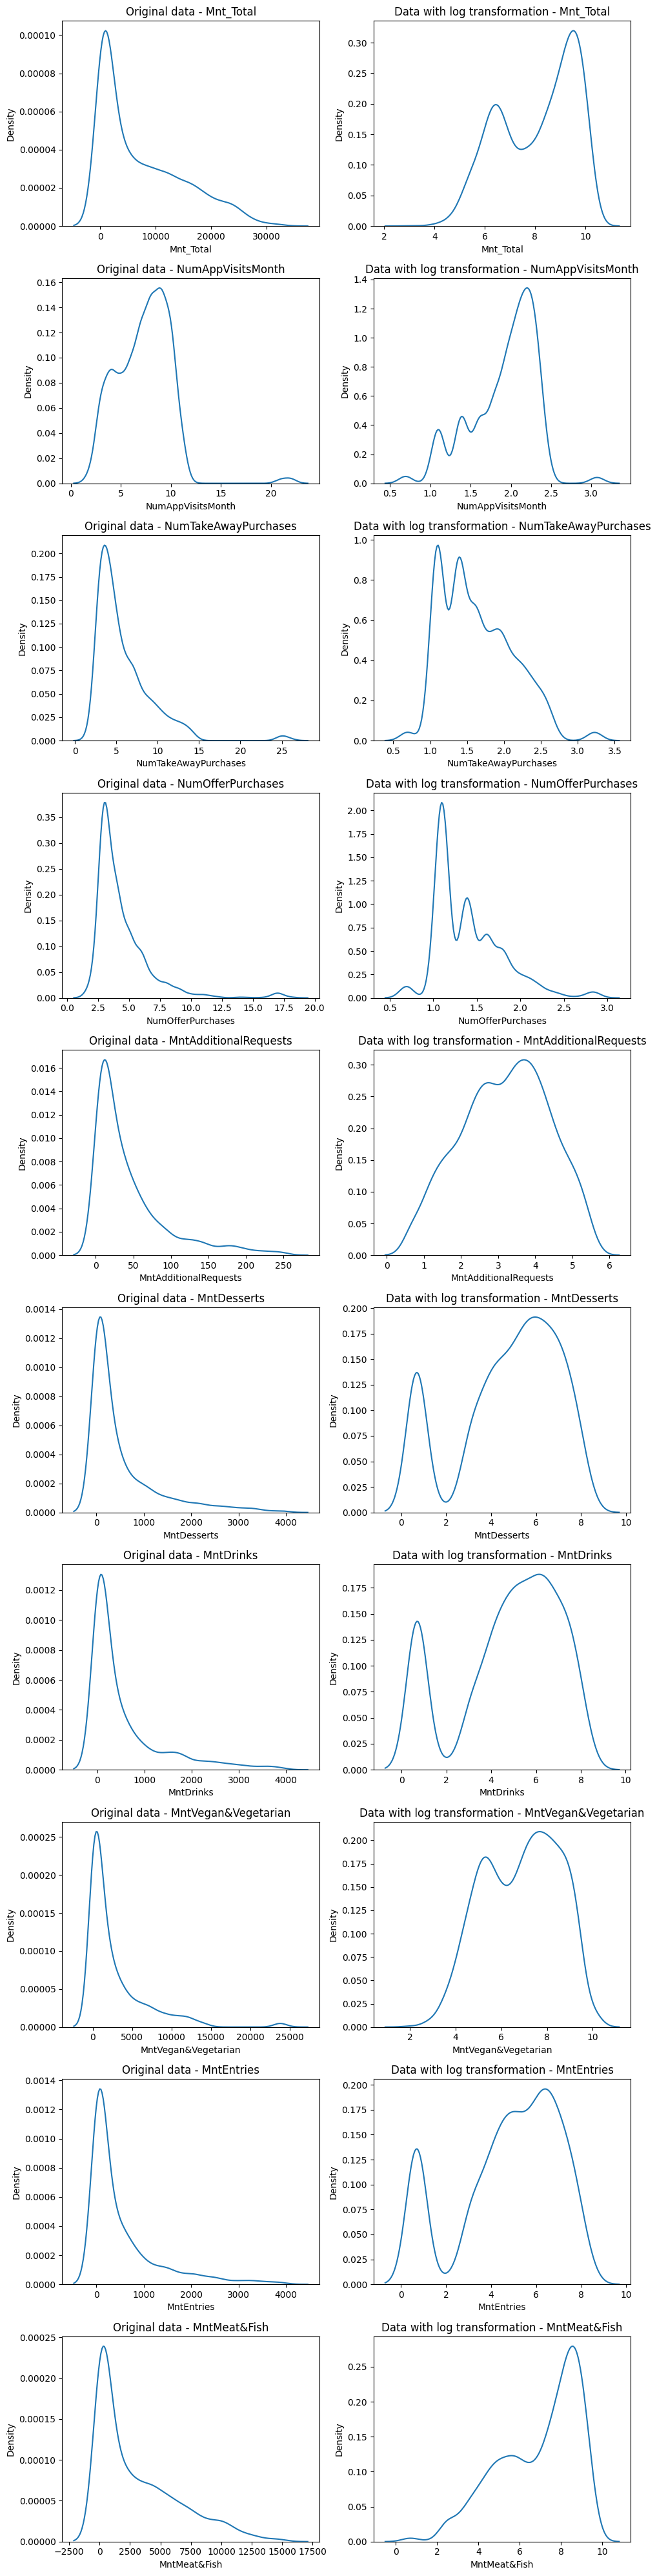

In [30]:
vars_to_log = ['Mnt_Total', 'NumAppVisitsMonth', 'NumTakeAwayPurchases', 'NumOfferPurchases', 'MntAdditionalRequests', 'MntDesserts', 'MntDrinks',
               'MntVegan&Vegetarian', 'MntEntries', 'MntMeat&Fish']

fig, axs = plt.subplots(len(vars_to_log), 2, figsize=(10, 4 * len(vars_to_log))) # len(vars_to_log) == the number of rows in the subplot grid which is == to the length of the list

log_transformed_vars = []

for i, var in enumerate(vars_to_log):
    x = numeric[var]

    log_trans = np.log(x)
    log_transformed_vars.append(log_trans)

    # Original data
    sns.kdeplot(x, ax=axs[i, 0])
    axs[i, 0].set_title(f'Original data - {var}')

    # Transformed data
    sns.kdeplot(log_trans, ax=axs[i, 1])
    axs[i, 1].set_title(f'Data with log transformation - {var}')

# Adjusting layout
plt.tight_layout()
plt.show()


Check OUTLIERS with log-transformed variables (log('Income') included) 

In [33]:
from scipy import stats

total_log =0
for i in log_transformed_vars:

    # Calculate Z-scores
    z_scores = np.abs(stats.zscore(i))

    # Define a threshold for outlier detection
    threshold = 3.5  # IF WE USE WITH 4 WE DON'T HAVE OUTLIERS

    # Identify outliers
    outliers = np.where(z_scores > threshold)[0]
    total_log += len(outliers)

    if len(outliers) > 0:
        print(f'{i.name} has {len(outliers)} outliers')

print(total_log)

NumOfferPurchases has 31 outliers
31


Nan's

- Education (categorical): Mode
- Recency: Which variables correlate more with Recency? (Median maybe because there is no high correlations)
- MntDrinks: High correlation with MntEntries, MntVegan&Vegetarian, MntDesserts and Mnt_Total 

In [21]:
# 'Education' nan's filled with mode

categorical.fillna(categorical['Education'].mode()[0], inplace = True)

<Axes: >

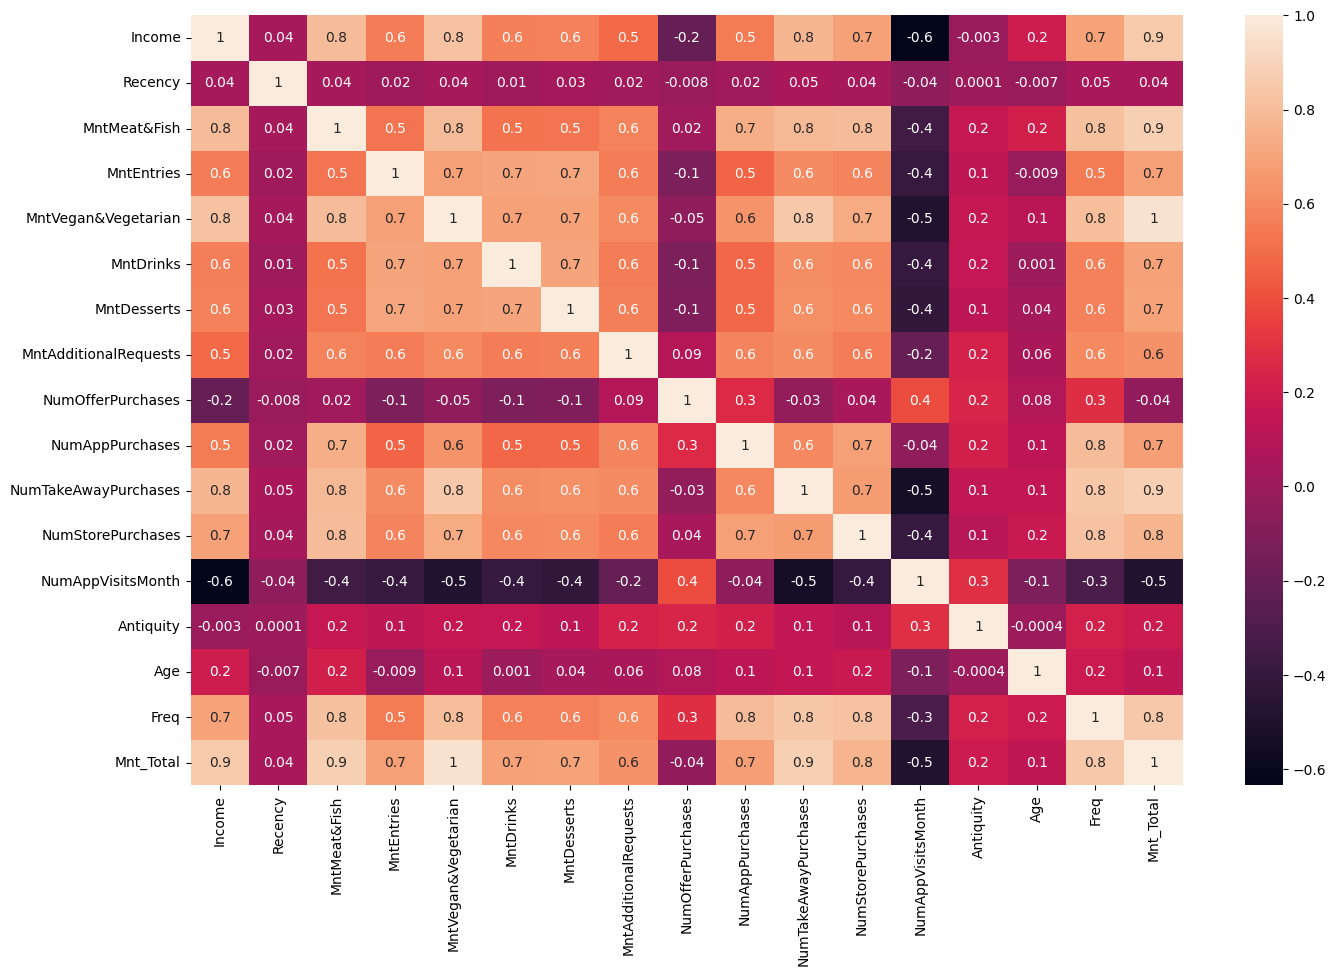

In [22]:
# Heatmap to assess correlations

numeric_corr = numeric.corr(method = 'spearman')

figure = plt.figure(figsize = (16, 10))

sns.heatmap(numeric_corr, annot = True, fmt = '.1g')

MNTDRIKNS

For now, we'll following the same approach from previous project. If in feature selection this feature reveals important to the model we'll try to improve this step.

Since MntDrinks correlates with MntEntries, MntVegan&Vegetarian, MntDesserts and Mnt_Total (0.7) lets use KNN imputer to fill the NA's. 

Report: A good strategy is to impute the missing values, i.e., to infer them from the known part of the data. 

In [23]:
from sklearn.impute import KNNImputer

numeric_knn = numeric[['MntDrinks', 'MntEntries', 'MntVegan&Vegetarian', 'MntDesserts', 'Mnt_Total']]

imputer = KNNImputer(n_neighbors = 1)

array_impute = imputer.fit_transform(numeric_knn)

In [26]:
numeric_knn = pd.DataFrame(array_impute, columns = numeric_knn.columns)

In [27]:
numeric['MntDrinks'] = numeric_knn['MntDrinks'].values

numeric.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 30651 to 15492
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Income                 2500 non-null   int64  
 1   Recency                2452 non-null   float64
 2   MntMeat&Fish           2500 non-null   int64  
 3   MntEntries             2500 non-null   int64  
 4   MntVegan&Vegetarian    2500 non-null   int64  
 5   MntDrinks              2500 non-null   float64
 6   MntDesserts            2500 non-null   int64  
 7   MntAdditionalRequests  2500 non-null   int64  
 8   NumOfferPurchases      2500 non-null   int64  
 9   NumAppPurchases        2500 non-null   int64  
 10  NumTakeAwayPurchases   2500 non-null   int64  
 11  NumStorePurchases      2500 non-null   int64  
 12  NumAppVisitsMonth      2500 non-null   int64  
 13  Antiquity              2500 non-null   int64  
 14  Age                    2500 non-null   int64  
 15 

RECENCY 

Filled with the median because there are no correlations

In [29]:
numeric.Recency.fillna(numeric.Recency.median(),inplace = True)

### Conclusions
- 18 duplicated rows - drop them 
- Nan's (Education - 33, Recency - 48, MntDrinks - 21)

- Categorical - 12 vars
    - Education - Try to reduce number of categories
    - Marital Status - Solve casing issues - Try to reduce number of categories
    - Response Campaign - Try to group in a single var (Number of campaigns responded) or maybe find a cutoff point
    - Kids- Try binary var(have or don't have)
    - Complain - low variability - Try drop
    - Target- DepVar - highly unbalanced set
    - Gender - highly unbalanced set
<br></br>
- Numeric
    - Incongruence in Freq (some has 0 but spent money) - set to 1 low values and remove two cases with high amount spent
    - Cost Contact and Revenue are constant - drop them
    - Outliers - try with and without
    - Distributions - apply transformation to help normalize 
    - Scaling - standardize 


Next Steps:
- Search statistical tests to detect outliers

- Cross Validation:
    - K-Fold Cross-Validation
    - Stratified K-Fold Cross-Validation
    - Leave-One-Out Cross-Validation (LOOCV)
    -Study/Search for methods for unbalanced sets

- Feature Selection
    - Categorical:
        - chi-square
        - Check others
    - Numerical:
        - __(1) Variance__ - To  understand if there are any constant variables;<br>
        - __(2) Spearman Correlation__ - To verify if there are any correlated features;<br>
        - __(3) Decision Trees__ - To just keep one variable from a group of correlated features;<br>
        - __(4) RFE__ - To iteratively select features by considering subsets of features;<br>
        - __(5) Lasso__ - To identify and select important features in a dataset;<br>
